Презентация: https://disk.yandex.ru/d/M6sb1jAscyx-PA

# Проект: Аналитика данных медицинского центра <a class="tocSkip">

Цель: проанализировать возможные причины изменения цены лечения в клинике в 2022 г. относительно 2021 г.  

Задачи:
- сравнить количество пациентов и предоставленных клиникой услуг по годам;
- выяснить, как изменилась цена на услуги клиники;
- определить, какие факторы влияют на цену лечения.

## Описание данных

- record_id - уникальный идентификатор строки данных;
- service_date - дата оказания медицинской услуги;
- service_name - наименование медицинской услуги;
- service_number - количество услуг;
- service_amount - сумма выплат (стоимость оказанных услуг в рублях);
- insured - уникальный идентификатор пациента;
- sex_id - пол пациента;
- age_for_service_date - возраст пациента.


## Загрузка данных

In [1]:
# загружаем нужные библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from datetime import datetime as dt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns 
#import scipy.stats as stats
from scipy import stats as st
from statsmodels. stats.weightstats import ztest as ztest

In [2]:
# загружаем данные
df = pd.read_excel('data_test_task_2022.xlsx')

In [3]:
df.head()

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
0,30268157003,2021-01-24,Прием первичный,1470,1,490777,2.0,26
1,30268157103,2021-01-24,"Взятие материала на посев, цитологическое иссл...",284,1,490777,2.0,26
2,30268157203,2021-01-24,"Посев отдел, дыхательных путей - слизистая зев...",1134,1,490777,2.0,26
3,30268157303,2021-01-24,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,490777,2.0,26
4,30268157403,2021-01-24,Ревматоидный фактор,420,1,490777,2.0,26


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85369 entries, 0 to 85368
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   record_id             85369 non-null  int64  
 1   service_date          85369 non-null  object 
 2   service_name          85369 non-null  object 
 3   service_amount        85369 non-null  int64  
 4   service_number        85369 non-null  int64  
 5   insured               85369 non-null  int64  
 6   sex_id                85348 non-null  float64
 7   age_for_service_date  85369 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 5.2+ MB


## Предобработка данных

In [5]:
# переименовываем столбцы
df.columns = ['record_id', 'date', 'service_name', 'total_bill', 'total_services', 'patient_id', 'sex', 'age']
df.head()

,record_id,date,service_name,total_bill,total_services,patient_id,sex,age
0,30268157003,2021-01-24,Прием первичный,1470,1,490777,2.0,26
1,30268157103,2021-01-24,"Взятие материала на посев, цитологическое иссл...",284,1,490777,2.0,26
2,30268157203,2021-01-24,"Посев отдел, дыхательных путей - слизистая зев...",1134,1,490777,2.0,26
3,30268157303,2021-01-24,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,490777,2.0,26
4,30268157403,2021-01-24,Ревматоидный фактор,420,1,490777,2.0,26


In [6]:
# ищем пропуски
df.isnull().sum()

record_id          0
date               0
service_name       0
total_bill         0
total_services     0
patient_id         0
sex               21
age                0
dtype: int64

У нас есть 21 пропуск в графе "пол", можем их удалить. 

In [7]:
# удаляем пропуски
df= df.dropna()
df.isnull().sum()

record_id         0
date              0
service_name      0
total_bill        0
total_services    0
patient_id        0
sex               0
age               0
dtype: int64

In [8]:
# ищем полные дубликаты
df.duplicated().sum()

0

Дубликатов нет.

In [9]:
# приводим данные к нужному типу
df['date']=pd.to_datetime(df['date'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85348 entries, 0 to 85368
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   record_id       85348 non-null  int64         
 1   date            85348 non-null  datetime64[ns]
 2   service_name    85348 non-null  object        
 3   total_bill      85348 non-null  int64         
 4   total_services  85348 non-null  int64         
 5   patient_id      85348 non-null  int64         
 6   sex             85348 non-null  float64       
 7   age             85348 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 5.9+ MB


In [11]:
# смотрим графу пол
df['sex'].unique()

array([2., 1.])

In [12]:
# заменяем значения пола
df['sex'].replace({2:'Female',1:'Male'},inplace=True)

In [13]:
# приводим название услуг к нижнему регистру
df['service_name'] = list(map(str.lower, df['service_name']))

In [14]:
#создаем колонку с ценой услуги
df['price'] = df['total_bill']/df['total_services']

Предобработка данных завершена, приступаем к анализу.

## Исследовательский анализ данных

### Период исследования

In [15]:
print(df['date'].min())
print(df['date'].max())

2021-01-03 00:00:00
2022-08-31 00:00:00


У нас есть данные с 3 января 2021 г. по 31 августа 2022 г. Данные за 2022 г. неполные, это может исказить показатели выручки.

In [16]:
# создадим столбец year с годом оказания услуги
df['year']=df['date'].dt.year
df.head()

,record_id,date,service_name,total_bill,total_services,patient_id,sex,age,price,year
0,30268157003,2021-01-24,прием первичный,1470,1,490777,Female,26,1470.0,2021
1,30268157103,2021-01-24,"взятие материала на посев, цитологическое иссл...",284,1,490777,Female,26,284.0,2021
2,30268157203,2021-01-24,"посев отдел, дыхательных путей - слизистая зев...",1134,1,490777,Female,26,1134.0,2021
3,30268157303,2021-01-24,"общий анализ крови (лейкоцитарная форм,, соэ)",693,1,490777,Female,26,693.0,2021
4,30268157403,2021-01-24,ревматоидный фактор,420,1,490777,Female,26,420.0,2021


### Пациенты

#### Количество пациентов по годам

In [17]:
# сколько всего уникальных пациентов в датасете
df['patient_id'].nunique()

4487

In [18]:
# количество пациентов по годам
patients = df.groupby('year').agg({'patient_id':'nunique'})
patients

,patient_id
year,
2021,2514
2022,2757


Всего в датасете есть 4487 уникальных пациентов. В 2021 г. их было 2514, в 2022 г. количество пациентов увеличилось до 2757.

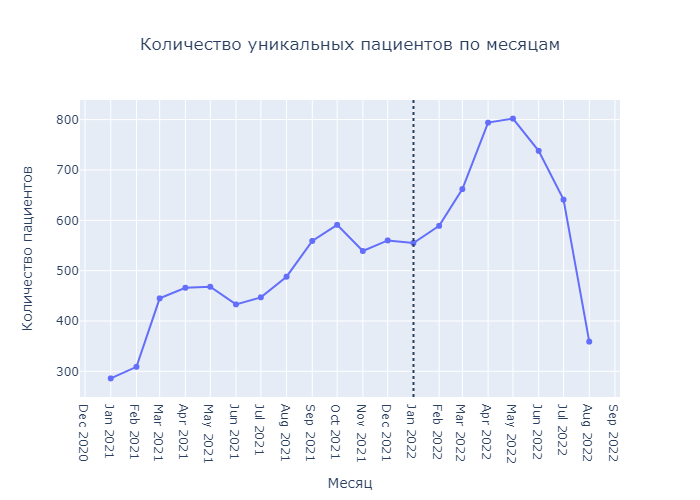

In [54]:
# количество пациентов в 2021 и 2022 гг. по месяцам 
df['year_month']=df['date'].dt.to_period("M").astype(str) #создаем колонку с месяцем и годом
patients_amt = df.groupby('year_month').agg({'patient_id':'nunique'}).reset_index()
patients_amt.columns=['year_month', 'unique_patients']

# визуализируем
fig = px.line(patients_amt, x='year_month', y='unique_patients', markers=True,
              title='Количество уникальных пациентов по месяцам')
fig.update_layout(xaxis_title='Месяц', yaxis_title='Количество пациентов')
fig.update_layout(legend=dict(title='Год')) #меняем заголовок легенды
fig.update_layout(title_xref="paper", title_x=0.5) #положение заголовка
#fig.update_xaxes(dtick= 1) # регулируем шаг отметок на оси х
fig.update_xaxes(dtick="M1")
fig.add_vline(x='2022-01', line_dash="dot") #добавляем линию, разделяющую два года
fig.show(renderer='png')

Количество уникальных пациентов клиники в 2021 г. увеличилось с 286 человек в январе до 560 человек в декабре. Мы наблюдаем резкий рост с февраля по март (с 309 чел. до 445 чел.). Больше всего пациентов в 2021 г. пришлось на октябрь: 591 человек. В 2022 г. количество пациентов росло с января (555 чел.) по май (802 чел.), а далее начало стремительно уменьшаться и составило всего 359 человек в августе, это самый низкий показатель с марта 2021. 

#### Пол и возраст пациентов

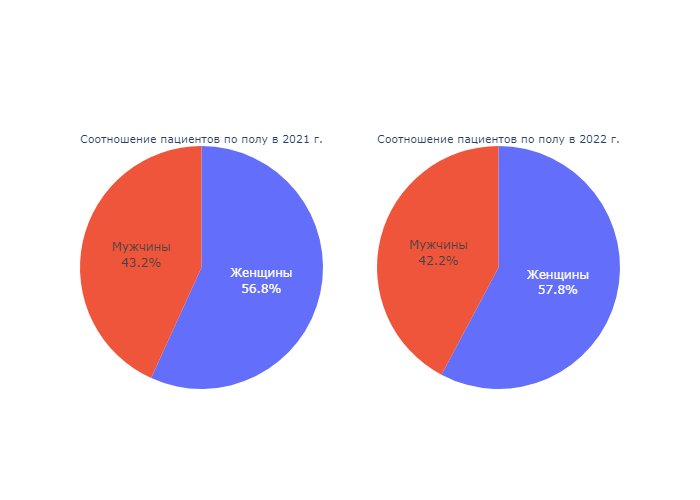

In [55]:
# соотношение пациентов по полу 
patients_2021 = df.query('year==2021')
patients_2022 = df.query('year==2022')
patients_gender_2021 = patients_2021.groupby(['sex']).agg({'patient_id':'nunique'}).reset_index()
patients_gender_2022 = patients_2022.groupby(['sex']).agg({'patient_id':'nunique'}).reset_index()
# визуализируем
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
labels=['Женщины','Мужчины']
fig.add_trace(go.Pie(values=patients_gender_2021['patient_id'], labels=labels,
             title='Соотношение пациентов по полу в 2021 г.'), 1, 1)
fig.add_trace(go.Pie(values=patients_gender_2022['patient_id'], labels=labels,
             title='Соотношение пациентов по полу в 2022 г.'), 1,2)
fig.update_layout(title_xref="paper", title_x=1) #положение заголовка
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update(layout_showlegend=False)
fig.show(renderer='png')

Соотношение пациентов по полу практически не изменилось в новом году: больше половины клиентов - женщины  (56,8% в 2021 г. и 57,8% в 2022 г.).

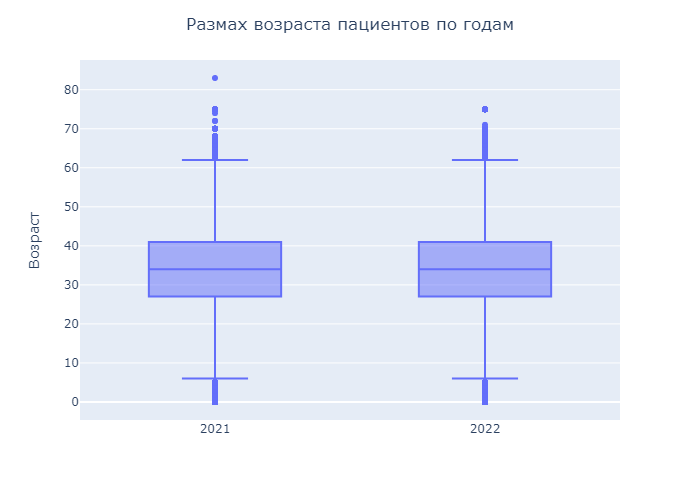

In [56]:
# возраст пациентов
fig = px.box(df, x='year', y='age')
fig.update_layout(title='Размах возраста пациентов по годам') #меняем заголовок 
fig.update_layout(xaxis_title='', yaxis_title='Возраст')
fig.update_layout(title_xref="paper", title_x=0.5) #положение заголовка
fig.show(renderer='png')

Возраст пациентов также остался неизменным: основную массу клиентов составляют пациенты от 6 до 62 лет, медианный возраст - 34 года.

Вывод: в 2021 г. в клинику обратилось 2514 человек, в 2022 г. количество клиентов увеличилось до 2757 (притом что информация за 2022 г. есть только до августа включительно).  Число пациентов плавно возрастало с января 2021 г. (286 чеовек) до мая 2022 г. (809 человек).  Начиная с мая 2022 г. количество пациентов начало уменьшаться, особенно выделяется резкий спад с июля 2022 г. (с 641 человека в июле до 359 в августе).  
Возрастно-половой состав пациентов по годам не изменился. Более половины пациентов клиники - женщины (56,8% в 2021г. и 57,8% в 2022 г.). Медианный возраст пациентов - 34 года, большая часть находятся в возрасте от 6 до 62 лет.

### Услуги

In [22]:
# всего уникальных услуг
print('Количество услуг:',df['service_name'].nunique())

Количество услуг: 875


In [23]:
# количество услуг по месяцам
df.groupby('year').agg({'service_name':'count'})

,service_name
year,
2021,44371
2022,40977


Всего в датасете 875 уникальных услуг. В 2021 г. пациентам было оказано 44371 услуг, а в 2022 г. - 40977 услуг (но данные за этот год неполные). Посмотрим, как меняется количество оказанных услуг по месяцам.

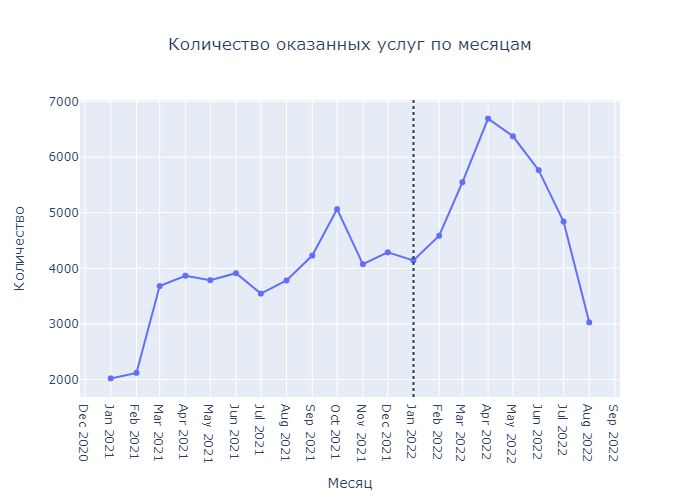

In [57]:
# количество оказанных услуг в 2021 и 2022 гг. по месяцам 
services_amt = df.groupby('year_month').agg({'patient_id':'count'}).reset_index()
services_amt.columns=['year_month', 'services_amount']

# визуализируем
fig = px.line(services_amt, x='year_month', y='services_amount', markers=True,
              title='Количество оказанных услуг по месяцам')
fig.update_layout(xaxis_title='Месяц', yaxis_title='Количество')
fig.update_layout(legend=dict(title='Год')) #меняем заголовок легенды
fig.update_layout(title_xref="paper", title_x=0.5) #положение заголовка
#fig.update_xaxes(dtick= 1) # регулируем шаг отметок на оси х
fig.add_vline(x='2022-01', line_dash="dot") #добавляем линию, разделяющую два года
fig.update_xaxes(dtick="M1")
fig.show(renderer='png')

График количества услуг ожидаемо практически повторяет график количества пациентов. Посмотрим, как различается количество услуг по годам в аналогичном периоде (сравнение по месяцам).

In [25]:
# создаем колонку month с месяцем 
df['month']=df['date'].dt.month

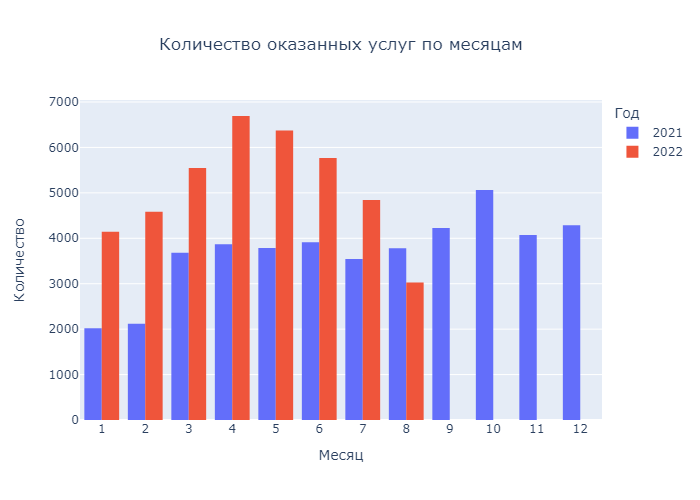

In [58]:
# количество оказанных услуг в 2021 и 2022 гг. по месяцам 
services = df.groupby(['year','month']).agg({'patient_id':'count'}).reset_index()
services.columns=['year', 'month', 'services_amount']

# визуализируем
fig = px.histogram(services, x='month', y='services_amount', color='year',
              barmode='group', 
              #histnorm='percent', #отображаем процентное соотношение, а не абсолютные значения     
              title='Количество оказанных услуг по месяцам')
fig.update_layout(xaxis_title='Месяц', yaxis_title='Количество')
fig.update_layout(legend=dict(title='Год')) #меняем заголовок легенды
fig.update_layout(title_xref="paper", title_x=0.5) #положение заголовка
fig.update_xaxes(dtick= 1) # регулируем шаг отметок на оси х
fig.update_xaxes(type='category') # регулируем отметки на оси х
fig.show(renderer='png')

За исключением августа, в каждом месяце клиника оказывала больше услуг в 2022 г., чем в 2021. Больше всего услуг было оказано в апреле 2022 г.: всего 6692 шт. (для сравнения - в 2021 г. самым "занятым" месяцем был октябрь с 5065 услугами).

#### Самые популярные услуги

In [27]:
# посмотрим на топ-10 услуг
df['service_name'].value_counts().head(10)

прием первичный                                  6053
прием повторный                                  4474
взятие крови из периферической вены              4214
общий анализ крови (лейкоцитарная форм,, соэ)    3189
магнитотерапия (1 сеанс)                         2838
взятие мазка                                     1567
общий анализ мочи                                1549
лазеротерапия (1 сеанс)                          1313
интерференционные токи (1 сеанс) (4 поля)        1195
гинекологический мазок                           1194
Name: service_name, dtype: int64

Больше всего в клинику обращаются за приемом к врачу, взятием и анализом крови, мазка и мочи. К популярным услугам также относится магнитотерапия, лазеротерапия и интерференционные токи.

#### Категории услуг

Всего клиника оказывает 875 уникальных услуг, для удобства дальнейшего анализа распределим их по категориям. Для этого название услуги разделим на отдельные слова и по ключевым словам отнесем услугу к той или иной категории. Ключевое слово "исследование" может относиться сразу к нескольким категориям (например, это может быть исследование крови, глазного дна и т.п.), поэтому в отборе по категориям мы не будем его учитывать. Многие услуги названы одним словом (например, "глюкоза"), поэтому не все они войдут в правильную категорию. Для таких услуг предусмотрена категория "другое".

In [28]:
df['service_name'] = list(map(str.lower, df['service_name'])) # приводим название услуг к нижнему регистру
df['words'] = df['service_name'].apply(lambda x: x.split(' ')) #создаем колонку words 
df['words']=df['words'].astype('str')
df.head()

,record_id,date,service_name,total_bill,total_services,patient_id,sex,age,price,year,year_month,month,words
0,30268157003,2021-01-24,прием первичный,1470,1,490777,Female,26,1470.0,2021,2021-01,1,"['прием', 'первичный']"
1,30268157103,2021-01-24,"взятие материала на посев, цитологическое иссл...",284,1,490777,Female,26,284.0,2021,2021-01,1,"['взятие', 'материала', 'на', 'посев,', 'цитол..."
2,30268157203,2021-01-24,"посев отдел, дыхательных путей - слизистая зев...",1134,1,490777,Female,26,1134.0,2021,2021-01,1,"['посев', 'отдел,', 'дыхательных', 'путей', '-..."
3,30268157303,2021-01-24,"общий анализ крови (лейкоцитарная форм,, соэ)",693,1,490777,Female,26,693.0,2021,2021-01,1,"['общий', 'анализ', 'крови', '(лейкоцитарная',..."
4,30268157403,2021-01-24,ревматоидный фактор,420,1,490777,Female,26,420.0,2021,2021-01,1,"['ревматоидный', 'фактор']"


In [29]:
# создаем датасеты по ключевым словам
visit = df['words'].str.contains(r"\прием|консультация\b")
ultra = df['words'].str.contains(r"\ультразвуковое|скрининг|узи\b")
oper = df['words'].str.contains(r"\взятие|инъекция|наложение|блокада|вакцинация|перевязка|удаление|обработка|биопсия|введение|вскрытие|установка|постановка|пункция|вливание|смазывание|катетеризация|промывание|тампонада|прижигание\b")
lab = df['words'].str.contains(r"\анализ|посев|соскоб|мазок|ттг|глюкоза|алт|билирубин|холестирин|креатинин|мочи|мочевина|белок|лейкоформула|соэ|т4|ггт|фактор|аллергопанель|витамин|кровь|крови|днк|ige|igg|igm|гистологическое|моче|моча|кал|кале|инсулин|гемоглобин|слюна|гормон|тестостерон|проба|железо|кальций|фосфор|антитела|пыльца\b")
massage = df['words'].str.contains(r"\массаж\b")
treatment = df['words'].str.contains(r"\диагностика|терапия|терапии|лечение|сеанс|сканирование|подбор|рефрактометрия|измерение|тест|осмотр|интерпретация|проведение\b")
xray = df['words'].str.contains(r"\рентгенография|рентген|снимок|мрт|мскт\b")

In [30]:
# присваиваем категории услугам в основном датасете
df.loc[visit, 'service_category'] = "прием"
df.loc[ultra, 'service_category'] = "узи"
df.loc[oper, 'service_category'] = "манипуляции"
df.loc[lab, 'service_category'] = "лаборатория"
df.loc[massage, 'service_category'] = "массаж"
df.loc[treatment, 'service_category'] = "диагностика и лечение"
df.loc[xray, 'service_category'] = "рентген и мрт"
df['service_category'] = df['service_category'].fillna("другое")

In [31]:
# получившиеся категории и количество услуг, оказанных в них
df['service_category'].value_counts()

прием                    26322
лаборатория              22584
диагностика и лечение    13827
другое                    9694
манипуляции               4556
узи                       4021
рентген и мрт             2597
массаж                    1747
Name: service_category, dtype: int64

Посмотрим, как меняется состав услуг, за которыми обращаются в клинику, по годам. Поскольку у нас нет информации за полный 2022 г., рассмотрим распределение услуг по категориям, а не их абсолютное количество.

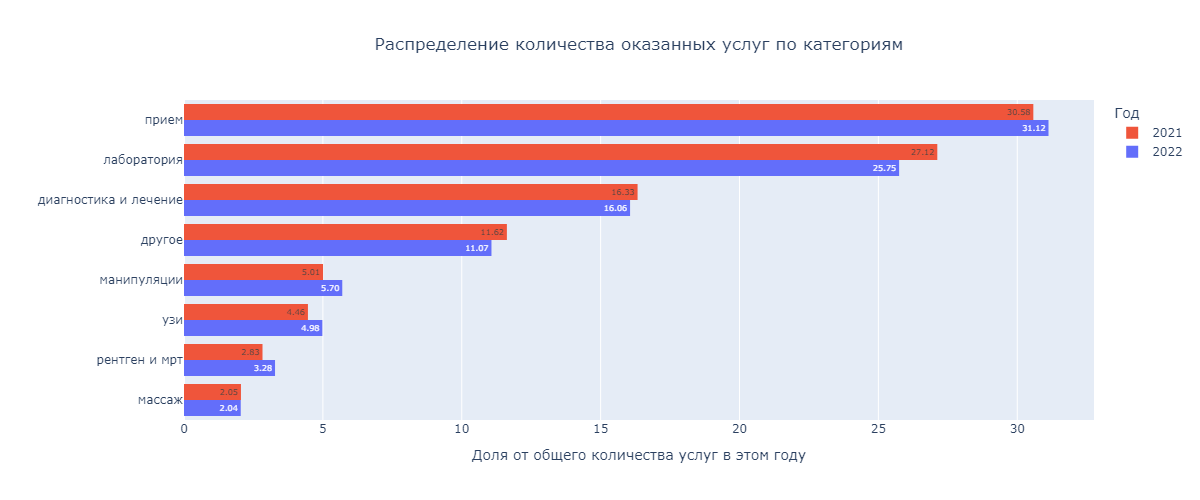

In [71]:
categories = df.groupby(['service_category', 'year']).agg({'patient_id':'count'}).sort_values(by='patient_id', ascending=True).reset_index()
fig = px.histogram(categories, x='patient_id', y='service_category', color='year',
              barmode='group', histnorm='percent', text_auto='.2f',
              title='Распределение количества оказанных услуг по категориям')
fig.update_layout(xaxis_title='Доля от общего количества услуг в этом году', yaxis_title='')
fig.update_xaxes(categoryorder='total ascending') #сортировка по оси у
fig.update_layout(legend=dict(title='Год')) #меняем заголовок легенды
fig.update_layout(legend={'traceorder':'reversed'}) #сортируем порядок легенды
fig.update_layout(title_xref="paper", title_x=0.5) #положение заголовка
fig.update_traces(textfont_size=8, textangle=0, textposition='inside', cliponaxis=True) #подписи на столбцах
fig.show(renderer='png', width = 1200)

В 2022 г. по сравнению с 2021 г. стали меньше обращаться за лабораторными исследованиями (с 27,% до 25,75%) и диагностикой и лечением (с 16,33% до 16,06%). Увеличилась доля приемов у врача (с 30,58% до 31,12%), медицинских манипуляций (с 5% до 5,7%), узи (с 4,46% до 4,98%), услуг рентгена и мрт (с 2,83% до 3,28%). 

#### Цены на услуги

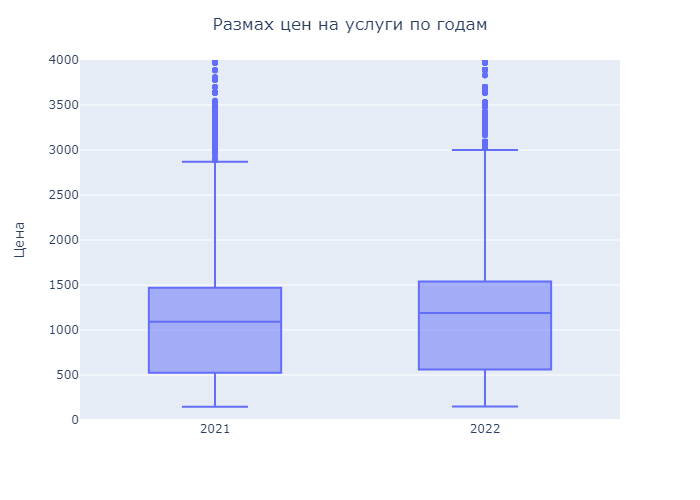

In [60]:
# цены на услуги
fig = px.box(df, x='year', y='price')
fig.update_layout(title='Размах цен на услуги по годам') #меняем заголовок 
fig.update_layout(xaxis_title='', yaxis_title='Цена')
fig.update_layout(title_xref="paper", title_x=0.5) #положение заголовка
fig.update_yaxes(range=[0,4000]) #ограничиваем ось
fig.show(renderer='png')

В новом году услуги подорожали: большинство услуг в 2021 г. стоят от 147 до 2870 руб., а в 2022 г. - от 150 до 3000 руб. Медианная стоимость услуги составила 1092 р. в 2021 г. и 1190 р. в 2022 г. 

In [34]:
#услуги дороже 3 тыс.
exp_services = df.query('price>3000')
exp_services.sort_values(by='price', ascending=False).head()
#exp_services.groupby('service_category').agg({'service_name':'count'})

,record_id,date,service_name,total_bill,total_services,patient_id,sex,age,price,year,year_month,month,words,service_category
18519,30961787103,2021-06-24,"гистерорезектоскопия при полипах , рдв",26999,1,362928,Female,51,26999.0,2021,2021-06,6,"['гистерорезектоскопия', 'при', 'полипах', ','...",другое
15588,30961493203,2021-06-17,мрт брюшной полости и забрюшинного пространств...,17325,1,634755,Male,41,17325.0,2021,2021-06,6,"['мрт', 'брюшной', 'полости', 'и', 'забрюшинно...",рентген и мрт
23794,31249334503,2021-08-20,мрт головного мозга и гипофиза с контрастирова...,15225,1,544627,Female,34,15225.0,2021,2021-08,8,"['мрт', 'головного', 'мозга', 'и', 'гипофиза',...",рентген и мрт
27994,31408821503,2021-09-09,мультипараметрическая мрт предстательной желез...,14175,1,531654,Male,59,14175.0,2021,2021-09,9,"['мультипараметрическая', 'мрт', 'предстательн...",рентген и мрт
37286,31680697303,2021-11-10,мрт органов малого таза с внутривенным контрас...,13780,1,596539,Female,27,13780.0,2021,2021-11,11,"['мрт', 'органов', 'малого', 'таза', 'с', 'вну...",рентген и мрт


Самые дорогие услуги - это гистерорезектоскопия при полипах, а также различные мрт-исследования.

Посмотрим, как изменилась цена на услуги в 2022 г.

In [35]:
pricing = pd.pivot_table(df, index=['service_name','service_category'], columns='year', values='price').reset_index()
pricing.columns=['service_name','service_category', 'year_2021', 'year_2022']
pricing['change'] = pricing['year_2021'] - pricing['year_2022'] #создаем колонку с изменением цены
pricing['change'] = abs(pricing['change']) #отображаем абсолютное значение изменение цены
pricing['change_rate'] = (pricing['year_2022'] - pricing['year_2021'])/pricing['year_2021']*100 #насколько изменилась цена
pricing.head()

,service_name,service_category,year_2021,year_2022,change,change_rate
0,"(1 e)аллергопанель ige (молоко коровье, молоко...",лаборатория,NaN,1520.0,NaN,NaN
1,"(2 e)аллергопанель ige (пшеничная мука, ржаная...",лаборатория,NaN,1520.0,NaN,NaN
2,"(3 e)аллергопанель ige (фасоль (бобы), горох, ...",лаборатория,NaN,1520.0,NaN,NaN
3,"(4 e)аллергопанель ige (говядина, телятина, св...",лаборатория,NaN,1520.0,NaN,NaN
4,"(б1 (11))аллергопанель ige шерсть кошки, шерст...",лаборатория,1466.75,1520.0,53.25,3.630476


В таблице есть пропуски - это услуги, которые перестали оказывать в 2022 г., либо новые услуги, которых в 2021 г. еще не было.

In [36]:
new_services = pricing[pricing['year_2021'].isna()]
print('Количество новых услуг в 2022 г.:', len(new_services))
discarded_services = pricing[pricing['year_2022'].isna()]
print('Количество услуг, которые больше не оказываются в 2022 г.:', len(discarded_services))

Количество новых услуг в 2022 г.: 136
Количество услуг, которые больше не оказываются в 2022 г.: 196


<b>Комментарий ревьюера:</b> Возможно, услуги были просто переименнованны. Без дополнительного исследования не стоит писать об их исчезновении либо возникновении.

In [37]:
# количество услуг, цена на которые уменьшилась
decreased_prices = pricing.query('change_rate < 0')
print('Количество услуг, цена на которые уменьшилась:', len(decreased_prices))

# количество услуг, цена на которые увеличилась
increased_prices = pricing.query('change_rate > 0')
print('Количество услуг, цена на которые увеличилась:', len(increased_prices))

Количество услуг, цена на которые уменьшилась: 1
Количество услуг, цена на которые увеличилась: 518


В 2022 г. увеличилась цена на 518 услуг, а уменьшилась всего на 1. Рассмотрим эти услуги подробнее.

In [38]:
# цена уменьшилась
decreased_prices

,service_name,service_category,year_2021,year_2022,change,change_rate
286,исследование мокроты,другое,809.0,600.0,209.0,-25.834363


In [39]:
df.query('service_name == "исследование мокроты"')

,record_id,date,service_name,total_bill,total_services,patient_id,sex,age,price,year,year_month,month,words,service_category
23348,31249288703,2021-08-05,исследование мокроты,809,1,680921,Female,29,809.0,2021,2021-08,8,"['исследование', 'мокроты']",другое
54785,32326921703,2022-03-27,исследование мокроты,600,1,873191,Male,28,600.0,2022,2022-03,3,"['исследование', 'мокроты']",другое


Единственная услуга, которая обошлась дешевле в 2022 г., чем в 2021 г. - это исследование мокроты. Она проводилась всего по одному разу в каждом году. Можно предположить, что пациент в 2022 г. имел какую-либо скидку или бонусные баллы в клинике, учитывая, что все остальные услуги не дешевеют. 

Посмотрим на то, как цены увеличились.

In [40]:
increased_prices_by_service = increased_prices.sort_values(by='change_rate', ascending=False)
round(increased_prices_by_service).head()

,service_name,service_category,year_2021,year_2022,change,change_rate
173,введение лекарственных препаратов в наружный с...,манипуляции,265.0,308.0,43.0,16.0
271,интерпретация результатов диаскинтеста,диагностика и лечение,1103.0,1280.0,177.0,16.0
15,chlamydia pneumoniae igg,лаборатория,599.0,690.0,91.0,15.0
609,проведение диаскинтеста,диагностика и лечение,1365.0,1570.0,205.0,15.0
786,ультразвуковое исследование большие сроки бере...,узи,3045.0,3500.0,455.0,15.0


In [41]:
increased_prices_by_category = increased_prices.groupby('service_category').agg({'service_name':'count', 'change_rate':['min', 'max','median']}).reset_index()
increased_prices_by_category

service_category service_name change_rate                     
                                count         min        max    median
0  диагностика и лечение           50    0.331825  16.047144  4.463441
1                 другое          128    0.161812   9.756098  4.683680
2            лаборатория          185    0.840336  15.191987  4.937952
3            манипуляции           54    0.257069  16.171617  4.842592
4                 массаж            8    2.517202   6.673743  3.665321
5                  прием           51    0.457980  13.608247  1.010283
6          рентген и мрт           25    2.325581   8.714044  4.322793
7                    узи           17    2.847317  14.942529  4.885075

Уровень подорожания услуг разнится по категориям. Самое высокое медианное подорожание наблюдается на лабораторные услуги: в среднем почти на 5%. Скорее всего, это связано с повышением цен на реагенты и обоорудование, с помощью которых проводятся исследования. Максимальное повышение на отдельные услуги составило 15%. Услуги в категориях "диагностика и лечение", "манипуляции", "узи" подорожали в среднем на 4,4-4,9%, "массаж" - на 3,6%. Практически не изменилась цена на прием (консультацию) у врачей: медианная цена повысилась всего на 1%.

Посмотрим на изменение цен в динамике в отдельных категориях.

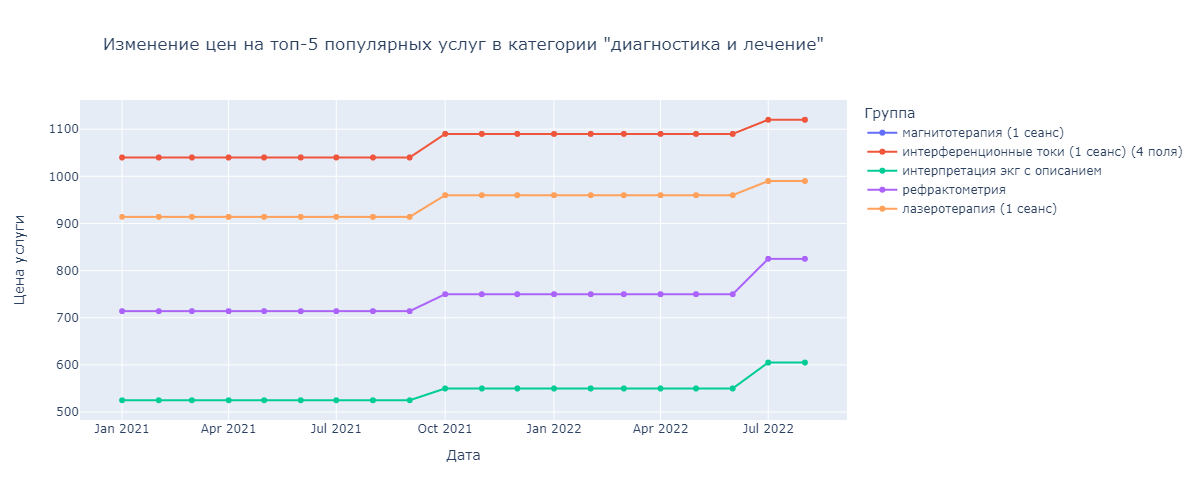

In [72]:
dia_top = df.query('service_category == "диагностика и лечение"')
dia_top = dia_top.groupby('service_name').agg({'patient_id':'count'}).sort_values(by='patient_id', ascending=False).reset_index().head(5)
dia_top_services = dia_top['service_name']
dia_change = df.query('service_name in @dia_top_services')
fig = px.line(dia_change, x='year_month', y='price', color='service_name',  markers=True,
              title='Изменение цен на топ-5 популярных услуг в категории "диагностика и лечение" ')
fig.update_layout(xaxis_title='Дата', yaxis_title='Цена услуги')
fig.update_layout(legend=dict(title='Группа')) #меняем заголовок легенды
fig.update_layout(title_xref="paper", title_x=0.5) #положение заголовка
fig.show(renderer='png', width = 1200)

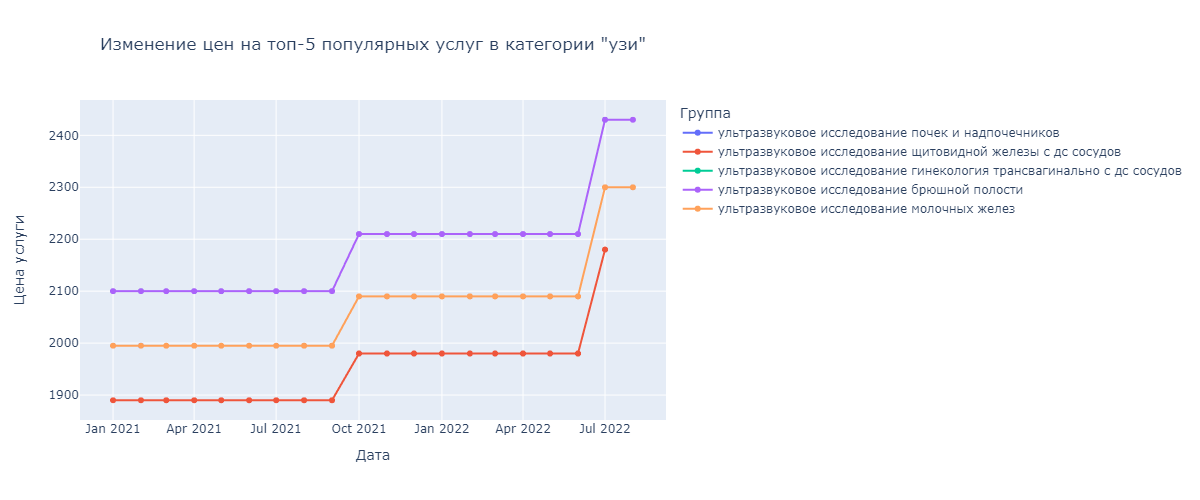

In [73]:
ultra_top = df.query('service_category == "узи"')
ultra_top = ultra_top.groupby('service_name').agg({'patient_id':'count'}).sort_values(by='patient_id', ascending=False).reset_index().head(5)
ultra_top_services = ultra_top['service_name']
ultra_change = df.query('service_name in @ultra_top_services')
fig = px.line(ultra_change, x='year_month', y='price', color='service_name',  markers=True,
              title='Изменение цен на топ-5 популярных услуг в категории "узи" ')
fig.update_layout(xaxis_title='Дата', yaxis_title='Цена услуги')
fig.update_layout(legend=dict(title='Группа')) #меняем заголовок легенды
fig.update_layout(title_xref="paper", title_x=0.5) #положение заголовка
fig.show(renderer='png', width = 1200)

Цены на некоторые виды узи совпадают, поэтому на графике накладываются друг на друга. По графикам мы наблюдаем два раунда повышения цен на услуги клиники: в октябре 2021 г. и в июле 2022 г. Видимо, цена на услуги клиники фиксированная, а повышение цен происходит планово один раз в год.

Вывод: клиника оказывает 875 уникальных услуг. Самые популярные - это первичный и повторный прием врача, а также взятие крови из вены и анализ крови.  
В 2021 г. пациентам было оказано 44371 услуг, а за неполный 2022 г. - 40977. В 2022 г. в каждом месяце клиника оказывала больше услуг, чем в 2021 г., кроме августа. Больше всего в 2021 г. пациенты обращались в клинику в октябре (5065 услуг), а в 2022 г. - в апреле (6692 услуг).  
В 2022 г. по сравнению с 2021 г. стали меньше обращаться за лабораторными исследованиями (с 27,% до 25,75%) и диагностикой и лечением (с 16,33% до 16,06%). Увеличилась доля приемов у врача (с 30,58% до 31,12%), медицинских манипуляций (с 5% до 5,7%), узи (с 4,46% до 4,98%), услуг рентгена и мрт (с 2,83% до 3,28%).  
Цены на услуги клиники повышались два раза: в октябре 2021 г. и в июле 2022 г. Медианная стоимость услуги составила 1092 р. в 2021 г. и 1190 р. в 2022 г. Уровень подорожания услуг разнится по категориям. Медианное увеличение на услуги в категориях "лаборатория", "диагностика и лечение", "манипуляции", "узи" составило от  4,4% до 4,9%, в категории "массаж" - на 3,6%, а на прием врачей - всего 1%. 

### Выручка

In [44]:
revenue = df.groupby('year').agg({'price':'sum'}).reset_index()
revenue['change']=revenue['price'][1]-revenue['price'][0]
revenue['change_rate']=(revenue['price'][1] - revenue['price'][0])/revenue['price'][0]*100
revenue

,year,price,change,change_rate
0,2021,49730356.0,-1354490.0,-2.723668
1,2022,48375866.0,-1354490.0,-2.723668


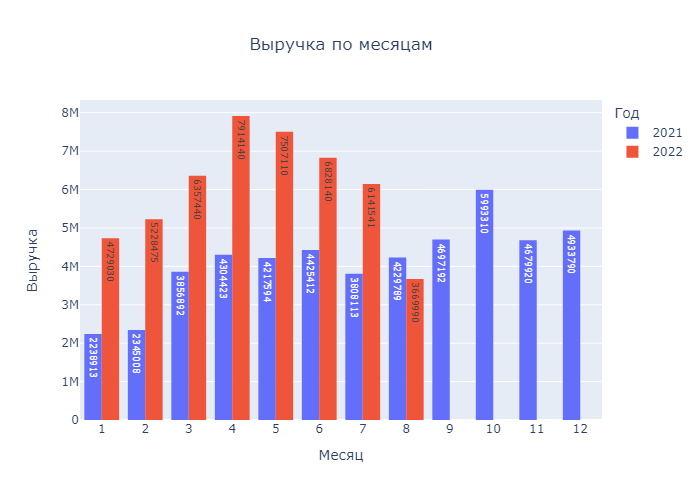

In [74]:
monthly_revenue = df.groupby(['year','month']).agg({'price':'sum'}).reset_index()
# визуализируем
fig = px.histogram(monthly_revenue, x='month', y='price', color='year',
              barmode='group',  text_auto='.0f',
              title='Выручка по месяцам')
fig.update_layout(xaxis_title='Месяц', yaxis_title='Выручка')
fig.update_layout(legend=dict(title='Год')) #меняем заголовок легенды
fig.update_layout(title_xref="paper", title_x=0.5) #положение заголовка
fig.update_xaxes(dtick= 1) # регулируем шаг отметок на оси х
#fig.update_xaxes(dtick="M1")
fig.update_xaxes(type='category') # регулируем отметки на оси х
fig.show(renderer='png')

Выручка за неполный 2022 г. всего на 2.7% меньше, чем за 2021 г. За каждый отдельный месяц, кроме августа, выручка в 2022 г. стабильно выше аналогичного периода в 2021 г.

### Лечение

Посмотрим на медианные показатели продолжительности и цены лечения в 2021 и 2022 гг., а также на медианное количество услуг на пациента.

In [46]:
# разделяем датасет по годам
year_2021 = df.query('year == 2021')
year_2022 = df.query('year == 2022')

In [47]:
# количество услуг
total_services_per_patient_2021 = year_2021.groupby('patient_id').agg({'service_name':'count'})
print('Медианное количество услуг на пациента в 2021 г.:', round(total_services_per_patient_2021['service_name'].median()))
total_services_per_patient_2022 = year_2022.groupby('patient_id').agg({'service_name':'count'})
print('Медианное количество услуг на пациента в 2022 г.:', round(total_services_per_patient_2022['service_name'].median()))

Медианное количество услуг на пациента в 2021 г.: 10
Медианное количество услуг на пациента в 2022 г.: 8


In [48]:
# продолжительность
lifetime_2021 = year_2021.groupby('patient_id').agg({'date':['min', 'max']}).reset_index()
lifetime_2021.columns=['patient_id', 'first_visit', 'last_visit']
lifetime_2021['lifetime'] = lifetime_2021['last_visit']-lifetime_2021['first_visit']
print('Медианная продолжительность использования услуг клиники в 2021 г.:', lifetime_2021['lifetime'].median())

lifetime_2022 = year_2022.groupby('patient_id').agg({'date':['min', 'max']}).reset_index()
lifetime_2022.columns=['patient_id', 'first_visit', 'last_visit']
lifetime_2022['lifetime'] = lifetime_2022['last_visit']-lifetime_2022['first_visit']
print('Медианная продолжительность использования услуг клиники в 2022 г.:', lifetime_2022['lifetime'].median())

Медианная продолжительность использования услуг клиники в 2021 г.: 16 days 00:00:00
Медианная продолжительность использования услуг клиники в 2022 г.: 13 days 00:00:00


In [49]:
# стоимость
treatment_cost_2021 = year_2021.groupby('patient_id').agg({'total_bill':'sum'}).reset_index()
print('Медианная стоимость лечения в 2021 г.:', treatment_cost_2021['total_bill'].median())

treatment_cost_2022 = year_2022.groupby('patient_id').agg({'total_bill':'sum'}).reset_index()
print('Медианная стоимость лечения в 2022 г.:', treatment_cost_2022['total_bill'].median())

Медианная стоимость лечения в 2021 г.: 10415.5
Медианная стоимость лечения в 2022 г.: 9730.0


Медианные показатели на пациента:
- В 2021 г. длительность лечения составляла 16 дней, количество услуг - 10. Стоимость лечения: 10415 руб.
- В 2022 г.  длительность лечения уменьшилась до 13 дней, а количество услуг - до 8. Стоимость лечения: 9730 руб.

Вывод: в 2022 г. в среднем пациенты лечатся быстрее и дешевле: медианный период лечения составляет 13 дней и стоит 9730 руб., при этом пациенты пользуются 8 услугами. В 2021 г. период лечения - 16 дней, стоимость - 10415 руб., а количество услуг - 10.

## Проверка гипотез

Исходя из исследовательского анализа данных, мы можем выдвинуть гипотезы о причинах изменения цены лечения в 2022 г. относительно 2021 г. 

Гипотеза 1. Средняя стоимость лечения в 2022 г. не изменилась относительно 2021 г.   
Гипотеза 2. Средняя стоимость лечения изменилась из-за изменения количества услуг на пациента.  
Гипотеза 3. Средняя стоимость лечения изменилась из-за подорожания услуг.  


In [50]:
# готовим датасет для проверки гипотез
lifetime = df.groupby('patient_id').agg({'date':['min', 'max'], 'total_bill':'sum', 'service_name':'count'}).reset_index() #считаем первый и последний визит для каждого пациента
lifetime.columns=['patient_id', 'first_visit', 'last_visit', 'treatment_cost', 'total_visits']
lifetime['lifetime'] = lifetime['last_visit']-lifetime['first_visit'] #считаем лайфайм каждого пациента
hyp = pd.merge(df, lifetime, left_on='patient_id', right_on='patient_id', how='outer') #добавляем даты первого и последнего визита, кол-во дней в датасет 
hyp['lifetime'] = hyp['lifetime']/ np.timedelta64(1, 'D') #приводим кол-во дней к типу float
#выборки для теста
patients_2021=hyp.query('year==2021').dropna()
patients_2022=hyp.query('year==2022').dropna()

### Гипотеза 1

Средняя стоимость лечения в 2022 г. не изменилась относительно 2021 г.  
Нулевая гипотеза: стоимость лечения не изменилась.  
Альтернативная гипотеза: стоимость лечения в 2022 г. отличается от таковой в 2021 г.

Мы проверяем отличие двух больших выборок (исследуем два генеральных средних), для этого используем Z-критерий.


In [51]:
# задаем уровень статистической значимости
alpha = 0.05 
group1 = np.array(patients_2021['treatment_cost'])
group2 = np.array(patients_2022['treatment_cost'])

#проводим тест
z_test_statistics, p_value = ztest(group1, group2, value= 0 ) 
print(z_test_statistics, p_value)
alpha=0.05
if p_value < alpha:
        print('Отвергаем нулевую гипотезу')
else:
        print('Не получилось отвергнуть нулевую гипотезу')

18.065331885404294 5.976150451175945e-73
Отвергаем нулевую гипотезу


По результатам теста мы отвергаем нулевую гипотезу: стоимость лечения в 2022 г. изменилась относительно стоимости лечения в 2021 г.

### Гипотеза 2

Средняя стоимость лечения изменилась из-за изменения количества услуг на пациента.  
Нулевая гипотеза: количество услуг на пациента не изменилось.  
Альтернативная гипотеза: количество услуг на пациента в 2022 г. отличается от такового в 2021 г.

Для гипотезы 2 и 3 мы проверяем значительно ли отличаются два независимых образца. Для этого мы можем использовать тест Манна-Уитни (для не нормально распределенных выборок) или  t-критерий Стьюдента. Поскольку выборки большие, тест Манна-Уитни подходит маленьких (<30) выборок, воспользуемся t-критерием. Для t-testa генеральные совокупности не обязаны быть нормально распределены, т.к. благодаря ЦПТ, при достаточном размере выборки (больше нескольких десятков значений), выборочные средние будут распределены нормально.

In [52]:
# задаем уровень статистической значимости
alpha = 0.05 
days_2021 = np.array(patients_2021['total_visits'])
days_2022 = np.array(patients_2022['total_visits'])
# проводим тест
results=st.ttest_ind(days_2021, days_2022)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 5.33573565445364e-106
Отвергаем нулевую гипотезу


По результатам теста мы отвергаем нулевую гипотезу: количество услуг на пациента в 2022 г. отличается от количества в 2021 г.

### Гипотеза 3

Средняя стоимость лечения изменилась из-за подорожания услуг.  
Нулевая гипотеза: средняя стоимость услуг в 2021 г. равна стоимости услуг в 2022 г.  
Альтернативная гипотеза: стоимость услуг статистически различается.  

In [53]:
# задаем уровень статистической значимости
alpha = 0.05 
prices_2021 = np.array(patients_2021['price'])
prices_2022 = np.array(patients_2022['price'])
# проводим тест
results=st.ttest_ind(prices_2021, prices_2022)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 2.0048497282169697e-29
Отвергаем нулевую гипотезу


По результатам теста мы отвергаем нулевую гипотезу: стоимость услуг в 2022 г. статистически отличается от стоимости услуг в 2022 г.

## Выводы

Мы провели исследование изменений показателей клиники за период с 3 января 2021 г. по 31 августа 2022 г. В 2021 г. в клинику обратилось 2514 человек, а в 2022 г. - 2757. Возрастно-половой состав пациентов по годам не изменился. Более половины пациентов клиники - женщины (56,8% в 2021г. и 57,8% в 2022 г.). Медианный возраст пациентов - 34 года, большая часть находятся в возрасте от 6 до 62 лет.  

Чаще всего в клинику обращаются за приемом у врача, а также взятием и анализом крови. В 2021 г. пациентам было оказано 44371 услуг, а за неполный 2022 г. - 40977. В 2022 г. по сравнению с 2021 г. стали меньше обращаться за лабораторными исследованиями (с 27,% до 25,75%) и диагностикой и лечением (с 16,33% до 16,06%). Увеличилась доля приемов у врача (с 30,58% до 31,12%), медицинских манипуляций (с 5% до 5,7%), узи (с 4,46% до 4,98%), услуг рентгена и мрт (с 2,83% до 3,28%).

Цены на услуги клиники повышались два раза: в октябре 2021 г. и в июле 2022 г. Медианная стоимость услуги составила 1092 р. в 2021 г. и 1190 р. в 2022 г. Уровень подорожания услуг разнится по категориям. Медианное увеличение на услуги в категориях "лаборатория", "диагностика и лечение", "манипуляции", "узи" составило от 4,4% до 4,9%, в категории "массаж" - на 3,6%, а на прием врачей - всего 1%.

Выручка за неполный 2022 г. всего на 2.7% меньше, чем за 2021 г. За каждый отдельный месяц, кроме августа, выручка в 2022 г. стабильно выше аналогичного периода в 2021 г.

В 2022 г.  медианный период лечения составляет 13 дней и стоит 9730 руб., при этом пациенты пользуются 8 услугами. В 2021 г. период лечения - 16 дней, стоимость - 10415 руб., а количество услуг - 10.

Мы проверили гипотезы об изменении средней стоимости лечения по годам. По результатам теста мы выяснили, что:
- Средняя стоимость лечения статистически различается. 
- Количество услуг на пациента в 2022 г. отличается от количества в 2021 г.
- Стоимость услуг в 2022 г. статистически отличается от стоимости услуг в 2022 г.

Таким образом, на стоимость лечения пациента в клинике влияет количество услуг на кейс, а также стоимость этих услуг.